# Jakub Muzyka & Jacek Paździerkiewicz 

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from functools import reduce
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer
from sparkdl import readImages as sparkdl_readImages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyspark
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import os
from pyspark.sql.functions import lit
from pyspark.sql.functions import concat
import tensorflow as tf 

2024-06-21 22:07:18.490271: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:07:18.495953: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:07:18.553741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 22:07:19.720309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from pyspark.sql import SparkSession
from PIL import Image
import numpy as np
from PIL import Image
import numpy as np
import tensorflow as tf
from spark_tensorflow_distributor import MirroredStrategyRunner
from pyspark.ml.feature import StringIndexer
from time import time
from functools import wraps
import os
import pyspark.sql.functions as F
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

In [ ]:
spark = SparkSession.builder.appName('Bird_Classificationv2').getOrCreate()

In [5]:
bird_df = spark.read.csv(path=r'/home/jacek/shared-drives/C:/Users/Jacek/projekt_big_data/Data/Birds/birds.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)
bird_df.show(n=5, truncate=False)

+--------+-----------------------------+---------------+--------+--------------------+
|class id|filepaths                    |labels         |data set|scientific name     |
+--------+-----------------------------+---------------+--------+--------------------+
|0.0     |train/ABBOTTS BABBLER/001.jpg|ABBOTTS BABBLER|train   |MALACOCINCLA ABBOTTI|
|0.0     |train/ABBOTTS BABBLER/007.jpg|ABBOTTS BABBLER|train   |MALACOCINCLA ABBOTTI|
|0.0     |train/ABBOTTS BABBLER/008.jpg|ABBOTTS BABBLER|train   |MALACOCINCLA ABBOTTI|
|0.0     |train/ABBOTTS BABBLER/009.jpg|ABBOTTS BABBLER|train   |MALACOCINCLA ABBOTTI|
|0.0     |train/ABBOTTS BABBLER/002.jpg|ABBOTTS BABBLER|train   |MALACOCINCLA ABBOTTI|
+--------+-----------------------------+---------------+--------+--------------------+
only showing top 5 rows



In [6]:
# tutaj musicie zdefiniować swoje ścieżki, czyli gdzie trzymacie te zdjęcia 
photo_path = r"/home/jacek/shared-drives/C:/Users/Jacek/projekt_big_data/"

In [7]:
bird_df = bird_df.withColumn("filepaths", concat(lit(photo_path), bird_df["filepaths"]))
bird_df.show(truncate=False)

+--------+---------------------------------------------------------------------------------------+---------------+--------+--------------------+
|class id|filepaths                                                                              |labels         |data set|scientific name     |
+--------+---------------------------------------------------------------------------------------+---------------+--------+--------------------+
|0.0     |/home/jacek/shared-drives/C:/Users/Jacek/projekt_big_data/train/ABBOTTS BABBLER/001.jpg|ABBOTTS BABBLER|train   |MALACOCINCLA ABBOTTI|
|0.0     |/home/jacek/shared-drives/C:/Users/Jacek/projekt_big_data/train/ABBOTTS BABBLER/007.jpg|ABBOTTS BABBLER|train   |MALACOCINCLA ABBOTTI|
|0.0     |/home/jacek/shared-drives/C:/Users/Jacek/projekt_big_data/train/ABBOTTS BABBLER/008.jpg|ABBOTTS BABBLER|train   |MALACOCINCLA ABBOTTI|
|0.0     |/home/jacek/shared-drives/C:/Users/Jacek/projekt_big_data/train/ABBOTTS BABBLER/009.jpg|ABBOTTS BABBLER|train   |MALACOC

In [10]:
img_path = '/home/jacek/shared-drives/C:/Users/Jacek/projekt_big_data/train/ABBOTTS BABBLER/001.jpg'
img_df = spark.read.format("image").load(img_path)
img_df.select("image.height", "image.width"
         ,"image.nChannels", "image.mode"
         ,"image.data").show()

+------+-----+---------+----+--------------------+
|height|width|nChannels|mode|                data|
+------+-----+---------+----+--------------------+
|   224|  224|        3|  16|[E6 EE EE E5 ED E...|
+------+-----+---------+----+--------------------+



In [12]:
img2vec = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x).flatten()), VectorUDT())
print(f'Image fields = {ImageSchema.imageFields}')
df_new = img_df.withColumn('vecs',img2vec('image'))

row_dict = df_new.first().asDict()
img_vec = row_dict['vecs']

img_dict = row_dict['image']
width = img_dict['width']
height = img_dict['height']
nChannels = img_dict['nChannels']
img_np = img_vec.reshape(height, width, nChannels)

m = np.ma.masked_greater(img_np, 100)
m_mask = m.mask
args = np.argwhere(m_mask)
for idx, (r, c, _) in enumerate(args):
    print(r, c, img_np[r,c])
    if idx > 5:
        break

Image fields = ['origin', 'height', 'width', 'nChannels', 'mode', 'data']


0 0 [230. 238. 238.]
0 0 [230. 238. 238.]
0 0 [230. 238. 238.]
0 1 [229. 237. 237.]
0 1 [229. 237. 237.]
0 1 [229. 237. 237.]
0 2 [228. 238. 238.]


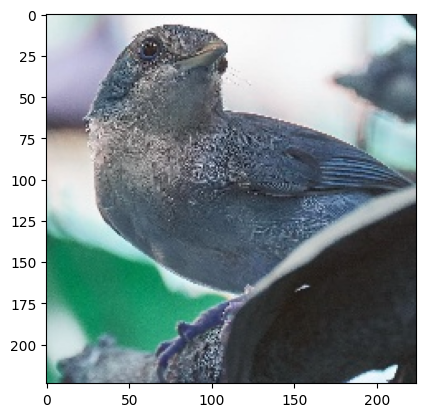

In [13]:
plt.imshow(img_np.astype("uint8"))

In [14]:
def convert_bgr_array_to_rgb_array(img_array):
    B, G, R = img_array.T
    return np.array((R, G, B)).T

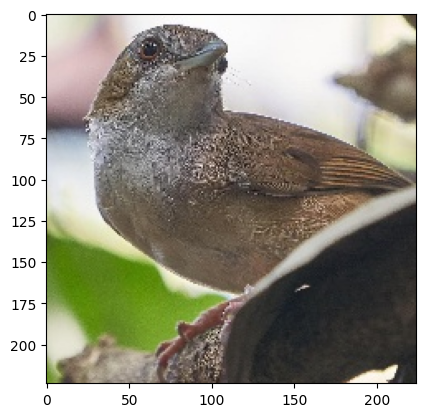

In [15]:
plt.imshow(convert_bgr_array_to_rgb_array(img_np).astype("uint8"))